NPZModel
     lightresponse: "lightresponse_linear"        
    nutrientuptake: "nutrientuptake_michaelismenten"
           grazing: "grazing_linear"
 phytoplanktonloss: "phytoplanktonloss_linear"
   zooplanktonloss: "zooplanktonloss_quadratic"



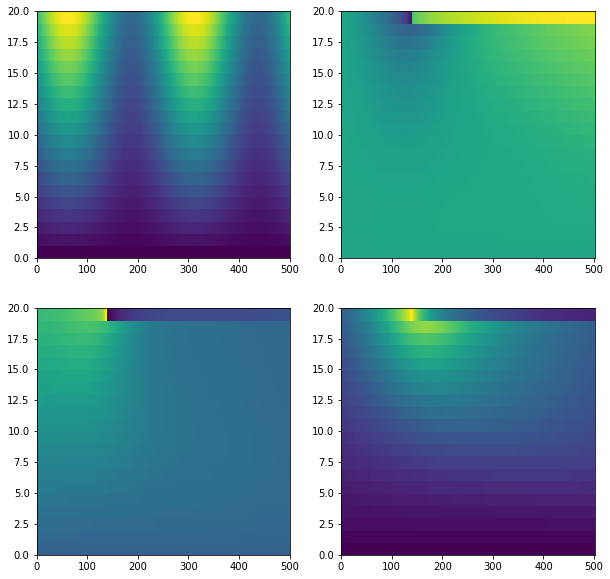

In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from npzmodel import NPZModel
from diffusion import diffusion

i_irr = 0
i_nut = 1
i_phy = 2
i_zoo = 3

class NPZModel1D(NPZModel):
    
    def run_nl(self, npz_ini, num_t):
        
        _, nx = npz_ini.shape

        # generate light
        light = self.generate_light(num_t+1)
        
        # create history
        x_nl_history = np.full(shape=(num_t+1,4,nx), fill_value=np.nan)
        x_nl_history[0,i_irr] = light[0] * np.arange(nx) / float(nx)
        x_nl_history[0,1:] = npz_ini
        
        # current conditions
        x_nl = x_nl_history[0,:].copy()
        
        for t in range(num_t):
            
            dx = 0.1
            for i in (i_nut, i_phy, i_zoo):
                x_nl[i] = diffusion(x_nl[i], 1e-6, self.delta_t, dx, nx)
            
            # call each model segment in sequence
            self.p_growth(x_nl)
            self.z_grazing(x_nl)
            self.p_loss(x_nl)
            self.z_loss(x_nl)
   
            # obtain light
            x_nl[i_irr] = light[t+1] * np.arange(nx) / float(nx)
            
            # record history
            x_nl_history[t+1,:] = x_nl
            
        return x_nl_history

nx = 20
npz_ini = np.zeros((3,nx))
npz_ini[0] = 10.
npz_ini[1] = np.linspace(0,5,nx)
npz_ini[2] = np.linspace(0,3,nx)
x_tl_ini = (1.0, 1.0, 0.2, 0.2)
num_t = 500

m = NPZModel1D()

print m

x_nl = m.run_nl(npz_ini, num_t)

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax = ax.flatten()
for i, axi in enumerate(ax):
    axi.pcolor(x_nl[:,i].T)

#ax.legend(('I','N','P','Z'))
#ax.grid(True)
#ax.set(title='nonlinear model simulation', xlabel='time step', 
#       ylabel='variable value')